# Calculating Final Metrics

In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import lpips
import plotly.express as px
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import save_image
from PIL import Image



from dataset import LTTDataset, load_data_from_dir
from latent_to_timestep_model import Delta_LTT_model, LTT_model, Huge_Delta_LTT_model
from models import prepare_stuff
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import (
    adjust_hyper,
    get_solvers,
    move_tensor_to_device,
    parse_arguments,
    set_seed_everything,
    visual
)

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")

sys.path.append('../')  # Act as if we are one directory higher so imports work
img_save_dir = 'graphics/'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:



args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)
training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


## Visualize all outputs compared to one another

In [ ]:


base_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated"

# Get the list of subdirectories in the base directory
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Sort subdirectories by nX in the back
subdirs_sorted = sorted(subdirs, key=lambda x: int(x.split('_n')[-1]))

# Create a figure with a grid layout
fig, axes = plt.subplots(len(subdirs_sorted), 5, figsize=(15, len(subdirs_sorted) * 3))
fig.subplots_adjust(wspace=0, hspace=0)  # Remove space between images

# Iterate through each sorted subdirectory
for row, subdir in enumerate(subdirs_sorted):
    subdir_path = os.path.join(base_dir, subdir)
    image_files = sorted([f for f in os.listdir(subdir_path) if f.endswith('.png')])[0:5]  # Get the first 5 images

    # Add subdirectory title to the left axis
    axes[row, 0].set_ylabel(subdir, rotation=0, size='large', labelpad=100, ha='right', va='center')
    axes[row, 0].yaxis.set_label_coords(-0.1, 0.5)  # Adjust label position

    # Plot the first 5 images
    for col, image_file in enumerate(image_files):
        image_path = os.path.join(subdir_path, image_file)
        img = Image.open(image_path)
        axes[row, col].imshow(img)
        axes[row, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Add red horizontal lines every 3 rows
    for r in range(3, len(subdirs_sorted), 3):
        for ax in axes[r, :]:
            ax.axhline(y=0, color='red', linewidth=2)
plt.show()

In [ ]:
from PIL import Image
import os

import matplotlib.pyplot as plt

img_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img"
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])[:10]

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, img_file in enumerate(img_files):
    img_path = os.path.join(img_dir, img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

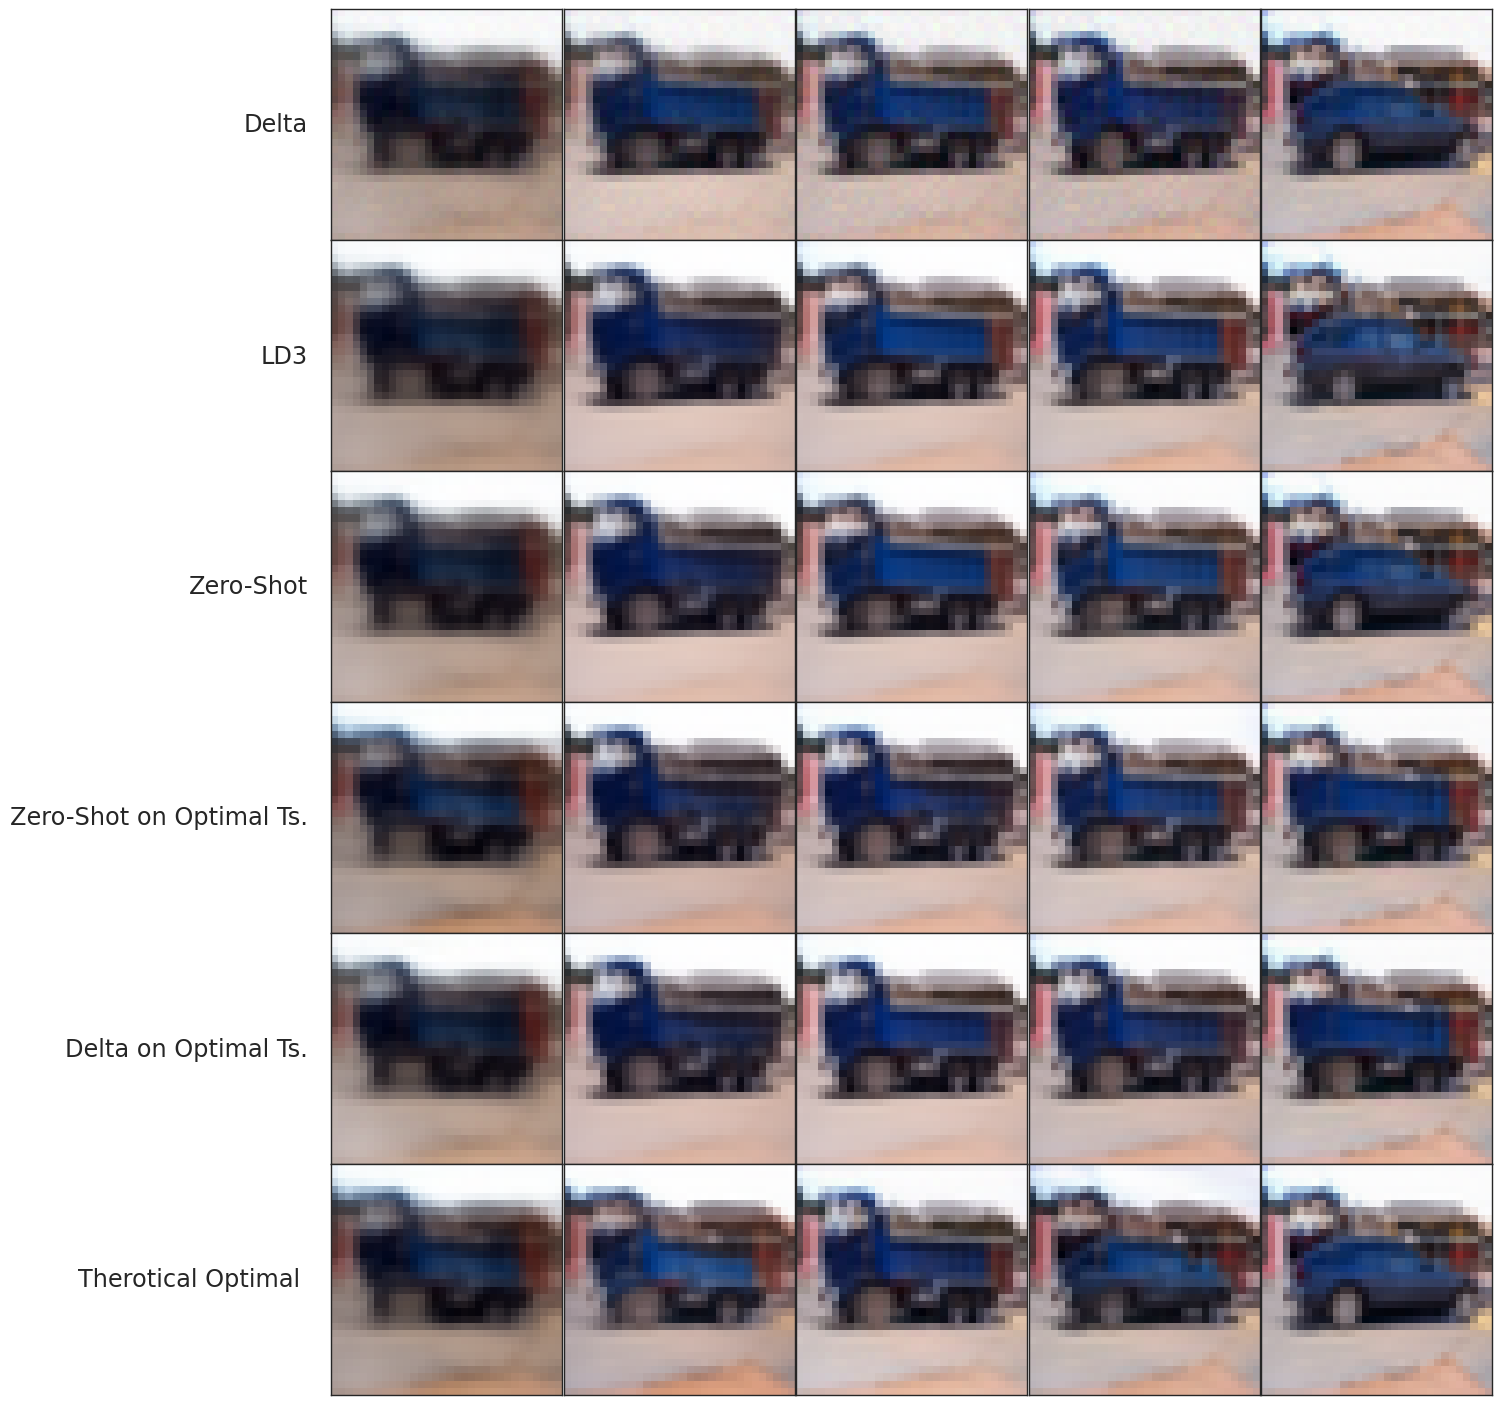

In [7]:
methods_to_visualize = [
    "delta",
    "ld3",
    "zeroshot",
    "zeroshot_optimal",
    "delta_optimal",
    "optimal_reproduced",
]

cleaner_names = [
    "Delta",
    "LD3",
    "Zero-Shot",
    "Zero-Shot on Optimal Ts.",
    "Delta on Optimal Ts.",
    "Therotical Optimal ",
]

n_steps = [3, 5, 6, 7, 10]
i_image = 0

reference_path = "fid-generated"


# Create a figure with a grid layout
fig, axes = plt.subplots(len(methods_to_visualize), 5, figsize=(15, len(methods_to_visualize) * 3))
fig.subplots_adjust(wspace=0, hspace=0)  # Remove space between images



for row, method in enumerate(methods_to_visualize):
    axes[row, 0].set_ylabel(cleaner_names[row], rotation=0, size='large', labelpad=100, ha='right', va='center')
    axes[row, 0].yaxis.set_label_coords(-0.1, 0.5)  # Adjust label position
    for col, n_step in enumerate(n_steps):
        img_path = os.path.join(reference_path, f"{method}_n{n_step}", f"{i_image}.png")
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()




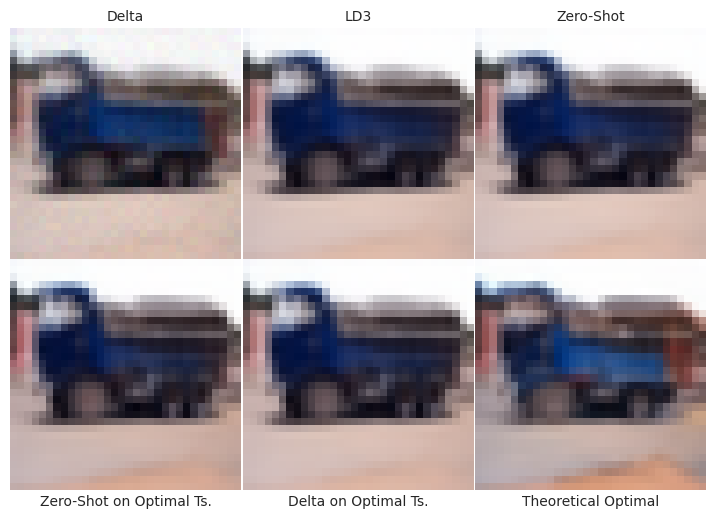

In [19]:
methods_to_visualize = [
    "delta",
    "ld3",
    "zeroshot",
    "zeroshot_optimal",
    "delta_optimal",
    "optimal_reproduced",
]

cleaner_names = [
    "Delta",
    "LD3",
    "Zero-Shot",
    "Zero-Shot on Optimal Ts.",
    "Delta on Optimal Ts.",
    "Theoretical Optimal",
]

n_step = 5
i_image = 0
reference_path = "fid-generated"

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(9, 6))
fig.subplots_adjust(wspace=0, hspace=0)

for idx, method in enumerate(methods_to_visualize):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]

    img_path = os.path.join(reference_path, f"{method}_n{n_step}", f"{i_image}.png")
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")

    label = cleaner_names[idx]

    if row == 0:
        # Title above image
        ax.text(0.5, 1.02, label, fontsize=10, ha='center', va='bottom', transform=ax.transAxes)
    else:
        # Title below image
        ax.text(0.5, -0.02, label, fontsize=10, ha='center', va='top', transform=ax.transAxes)

plt.show()

## Global

In [ ]:
#My implementation

n3_params = torch.tensor([0.3125, 0.1682, 0.1343, 0.3851], device='cuda:0')
n3_timestep = torch.tensor([[8.0000e+01, 5.9884e+00, 7.5587e-01, 2.0000e-03]], device='cuda:0')

n5_params = torch.tensor([0.2225, 0.1482, 0.1034, 0.0818, 0.0839, 0.3603], device='cuda:0')
n5_timestep = torch.tensor([[8.0000e+01, 1.0621e+01, 2.5949e+00, 8.5124e-01, 2.7130e-01, 2.0000e-03]],
       device='cuda:0')

n6_params = torch.tensor([0.0437, 0.1651, 0.1108, 0.0790, 0.1370, 0.0390, 0.1000, 0.3254],
       device='cuda:0')
n6_timestep = torch.tensor([[8.0000e+01, 1.2833e+01, 3.7612e+00, 1.5670e+00, 3.4353e-01, 2.2291e-01,
         7.3629e-02, 2.0000e-03]], device='cuda:0')

n7_params = torch.tensor([0.1246, 0.1541, 0.1057, 0.0844, 0.0897, 0.0760, 0.3655],
       device='cuda:0')
n7_timestep = torch.tensor([[8.0000e+01, 1.2389e+01, 3.4480e+00, 1.2409e+00, 4.1899e-01, 1.6694e-01,
         2.0000e-03]], device='cuda:0')

n10_params = torch.tensor([0.0994, 0.1309, 0.0971, 0.0447, 0.0592, 0.0616, 0.1001, 0.0391, 0.0728,
        0.0754, 0.2196], device='cuda:0')
n10_timestep =  torch.tensor([[8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
         2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03]],
       device='cuda:0')

In [ ]:
#LD3
# Load timesteps for n6
ld3_n6_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N6-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n6_dict = torch.load(ld3_n6_path, map_location=device)
ld3_n6_timestep = ld3_n6_dict['best_t_steps'][:len(ld3_n6_dict['best_t_steps']) // 2]

# Load timesteps for n3
ld3_n3_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N3-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n3_dict = torch.load(ld3_n3_path, map_location=device)
ld3_n3_timestep = ld3_n3_dict['best_t_steps'][:len(ld3_n3_dict['best_t_steps']) // 2]

# Load timesteps for n5
ld3_n5_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N5-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n5_dict = torch.load(ld3_n5_path, map_location=device)
ld3_n5_timestep = ld3_n5_dict['best_t_steps'][:len(ld3_n5_dict['best_t_steps']) // 2]

# Load timesteps for n7
ld3_n7_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N7-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n7_dict = torch.load(ld3_n7_path, map_location=device)
ld3_n7_timestep = ld3_n7_dict['best_t_steps'][:len(ld3_n7_dict['best_t_steps']) // 2]

# Load timesteps for n10
ld3_n10_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N10-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n10_dict = torch.load(ld3_n10_path, map_location=device)
ld3_n10_timestep = ld3_n10_dict['best_t_steps'][:len(ld3_n10_dict['best_t_steps']) // 2]

In [ ]:
def evaluate_params(params: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        print(i)
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        
        timestep = dis_model.convert(params.unsqueeze(0))
        print(timestep)

        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep[0],
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)


for name, params in zip(["n3", "n5", "n6", "n7", "n10"], [n3_params, n5_params,n6_params, n7_params, n10_params]):
    print(f"Loss for {name}: {evaluate_params(params)}")

Time taken:  21.534754753112793  
Loss for n3: 0.27483632415533066  
Time taken:  35.639776945114136  
Loss for n5: 0.14499929174780846  
Time taken:  49.86462879180908  
Loss for n6: 0.08154943212866783  
Time taken:  42.588207721710205  
Loss for n7: 0.11239975690841675  
Time taken:  70.93965196609497  
Loss for n10: 0.027583551593124866  

In [ ]:
def evaluate_timestep(timestep: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        
        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep,
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)

for name, timestep in zip(["n3", "n5", "n6", "n7", "n10"], [ld3_n3_timestep, ld3_n5_timestep, ld3_n6_timestep, ld3_n7_timestep, ld3_n10_timestep]):
    print(f"Loss for {name}: {evaluate_timestep(timestep)}")

Time taken:  7.843273401260376  
Loss for n3: 0.2787010371685028  
Time taken:  12.100373268127441  
Loss for n5: 0.1452961415052414  
Time taken:  14.393749952316284   
Loss for n6: 0.11326901987195015  
Time taken:  16.84900426864624  
Loss for n7: 0.08341463096439838  
Time taken:  23.266944408416748  
Loss for n10: 0.03293218836188316  

#### Variable Last Step

In [ ]:
def evaluate_params(timesteps: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        print(i)
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        

        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timesteps,
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)


for steps in [3, 5, 6, 7, 10]:
    model_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/model_N{steps}_lr0.001_batch3_nTrain200000_FinalGlobalVariableLastStep"
    timesteps = torch.load(model_path, map_location=device)["timesteps"]
    print(f"Loss for {steps}: {evaluate_params(timesteps)}")

### Bad Schedules

In [ ]:
timestep_large = torch.tensor([80.0, 60, 40, 30, 20, 10,
        5, 1, 0.5, 0.3, 0.1],
       device=device)

timestep_small = torch.tensor([80.0, 30, 5,1, 0.1, 0.005, 0.001,
        0.0005, 0.0001, 0.00005, 0.00001],
       device=device)

timestep_optimal = torch.tensor([8.0000e+01, 4.2390e+01, 3.3400e+00, 1.4845e+00, 6.6336e-01, 2.7701e-01,
        1.2638e-01, 6.4367e-02, 3.0538e-02, 9.6005e-03, 2.0000e-03],
       device=device)

In [ ]:
def evaluate_timestep(timestep: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        
        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep,
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)


for name, timestep in zip(["large", "small", "optimal"], [timestep_large, timestep_small, timestep_optimal]):
    print(f"Loss for {name}: {evaluate_timestep(timestep)}")

### Static Schedules (eg. Linear, Cosine, ...)

In [ ]:
def evaluate_timestep(timestep: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        
        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep,
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)

In [ ]:
vp_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/vp_0.pt"
vp_state_dict = torch.load(vp_model_path, map_location=device)
ve_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/ve_0.pt"
ve_state_dict = torch.load(ve_model_path, map_location=device)
iddpm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/iddpm_0.pt"
iddpm_state_dict = torch.load(iddpm_model_path, map_location=device)
edm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/edm_0.pt"
edm_state_dict = torch.load(edm_model_path, map_location=device)

In [ ]:
print("With 0 Step")
for name, state_dict in zip(["vp", "ve", "iddpm", "edm"], [vp_state_dict, ve_state_dict, iddpm_state_dict, edm_state_dict]):
    for steps in [3, 5, 6, 7, 10]:
        timesteps = state_dict[steps]
        print(f"Loss for {name} N{steps}: {evaluate_timestep(timesteps)}")

In [ ]:
vp_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/vp_not_0.pt"
vp_state_dict = torch.load(vp_model_path, map_location=device)
ve_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/ve_not_0.pt"
ve_state_dict = torch.load(ve_model_path, map_location=device)
iddpm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/iddpm_not_0.pt"
iddpm_state_dict = torch.load(iddpm_model_path, map_location=device)
edm_model_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs_global_timesteps/models/edm_not_0.pt"
edm_state_dict = torch.load(edm_model_path, map_location=device)

In [ ]:
print("Without 0 Step")
for name, state_dict in zip(["vp", "ve", "iddpm", "edm"], [vp_state_dict, ve_state_dict, iddpm_state_dict, edm_state_dict]):
    for steps in [3, 5, 6, 7, 10]:
        timesteps = state_dict[steps]
        print(f"Loss for {name} N{steps}: {evaluate_timestep(timesteps)}")

## Theoretical Optimum

In [ ]:
for n_steps in [3, 5, 6, 7, 10]:
    dir_path = f"/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/opt_t_final_{n_steps}"
    opt_t_files = os.listdir(dir_path) 


    loss_np = np.zeros((len(opt_t_files)))

    for i,file_path in enumerate(opt_t_files):
        opt_t_path = os.path.join(dir_path, file_path)
        opt_t = torch.load(opt_t_path, weights_only=True)[1][0]
        loss_np[i] = opt_t


    print(f"Mean loss of optimal train timesteps for {n_steps} steps: {np.mean(loss_np):.4f}")



In [ ]:
[f for f in os.listdir(dir_path) if f.endswith(f"n{n_steps}.pth")]

## Single Shot


In [ ]:
def evaluate_single_shot(n_steps: int) -> float:    
    start_time = time.time()

    ltt_model = LTT_model(steps=n_steps)
    state_dict = torch.load(f"/netpool/homes/connor/DiffusionModels/LD3_connor/runs_zeroshot_timesteps/models/steps_{n_steps}_model_lr0.0005_batch3_final_runs", weights_only=True)
    ltt_model.load_state_dict(state_dict)  # Load the model state
    ltt_model = ltt_model.to(device)
    ltt_model.eval()
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
                continue
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            
            timesteps = dis_model.convert(ltt_model(latent))
            latent = trainer.noise_schedule.prior_transformation(latent)
            x_next_finished = []

            for timestep, single_latent in zip(timesteps, latent):
                x_next = trainer.solver.sample_simple(
                    model_fn=trainer.net,
                    x=single_latent.unsqueeze(0),
                    timesteps=timestep,
                    order=trainer.order,
                    NFEs=n_steps,
                    **trainer.solver_extra_params,
                    )
                x_next = trainer.decoding_fn(x_next)
                x_next_finished.append(x_next)

            x_next = torch.cat(x_next_finished, dim=0)
            trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
            loss = trainer.loss_vector.mean().item() 
            loss_list.append(loss)
        print("Time taken: ", time.time() - start_time)
        return np.mean(loss_list)


for n_step in [3,5,6,7,10]:
    print(f"Loss for {n_step}: {evaluate_single_shot(n_step)}")




In [ ]:
n_steps = 5  # Change this to the number of steps you want to evaluate
ltt_model = LTT_model(steps=n_steps)
state_dict = torch.load(f"/netpool/homes/connor/DiffusionModels/LD3_connor/runs_zeroshot_timesteps/models/steps_{n_steps}_model_lr0.0005_batch3_final_runs", weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state
ltt_model = ltt_model.to(device)
ltt_model.eval()

### With Optimal Timesteps

In [ ]:
def evaluate_single_shot(n_steps: int) -> float:    
    start_time = time.time()

    ltt_model = LTT_model(steps=n_steps)
    state_dict = torch.load(f"/netpool/homes/connor/DiffusionModels/LD3_connor/runs_zeroshot_optimal_timesteps/models/steps_{n_steps}_model_lr0.0005_batch3_final_runs", weights_only=True)
    ltt_model.load_state_dict(state_dict)  # Load the model state
    ltt_model = ltt_model.to(device)
    ltt_model.eval()
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
                continue
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            
            timesteps = dis_model.convert(ltt_model(latent))
            latent = trainer.noise_schedule.prior_transformation(latent)
            x_next_finished = []

            for timestep, single_latent in zip(timesteps, latent):
                x_next = trainer.solver.sample_simple(
                    model_fn=trainer.net,
                    x=single_latent.unsqueeze(0),
                    timesteps=timestep,
                    order=trainer.order,
                    NFEs=n_steps,
                    **trainer.solver_extra_params,
                    )
                x_next = trainer.decoding_fn(x_next)
                x_next_finished.append(x_next)

            x_next = torch.cat(x_next_finished, dim=0)
            trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
            loss = trainer.loss_vector.mean().item() 
            loss_list.append(loss)
        print("Time taken: ", time.time() - start_time)
        return np.mean(loss_list)


for n_step in [3,5,6,7,10]:
    print(f"Loss for {n_step}: {evaluate_single_shot(n_step)}")

## Recursive Delta Prediction

### Variable Last Step

In [ ]:

n_steps_list = [3, 5, 6, 7, 10]
model_path_list = [
    "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalDelta",   
    "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalDelta",
    "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalDelta"
]

for n_steps, path in zip(n_steps_list, model_path_list):
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Running Test set for {n_steps} steps")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
        

### Fixed Last Step

In [ ]:

n_steps_list = [3, 5, 6, 7, 10]
model_path_list = [
    "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalDeltaFixedLastStep",
    "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalDeltaFixedLastStep",
    "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalDeltaFixedLastStep",
    "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalDeltaFixedLastStep",
    "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalDeltaFixedLastStep"
]

for n_steps, path in zip(n_steps_list, model_path_list):
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Running Test set for {n_steps} steps")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=True,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
        

### With Optimal Timesteps

In [ ]:

n_steps_list = [3, 5, 6, 7, 10]
model_path_list = [
    "runs_delta_optimal_timesteps/models/N3_model_lr5e-05_batch3_nTrain50000_FinalDeltaOptimalTimesteps",
    "runs_delta_optimal_timesteps/models/N5_model_lr5e-05_batch3_nTrain50000_FinalDeltaOptimalTimesteps",
    "runs_delta_optimal_timesteps/models/N6_model_lr5e-05_batch3_nTrain50000_FinalDeltaOptimalTimesteps",
    "runs_delta_optimal_timesteps/models/N7_model_lr5e-05_batch3_nTrain50000_FinalDeltaOptimalTimesteps",
    "runs_delta_optimal_timesteps/models/N10_model_lr5e-05_batch3_nTrain50000_FinalDeltaOptimalTimesteps"
]

for n_steps, path in zip(n_steps_list, model_path_list):
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Running Test set for {n_steps} steps")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=True,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
        

### Just Passing Image

In [ ]:
n_steps_list = [3, 5, 6, 7, 10]
model_path_list = [
    "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalDeltaJustImage",
    "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalDeltaJustImage",
    "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalDeltaJustImage",
    "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalDeltaJustImage",
    "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalDeltaJustImage"
]

for n_steps, path in zip(n_steps_list, model_path_list):
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Running Test set for {n_steps} steps")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout, just_image=True)

    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=True,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
        

### Different Sizes

In [ ]:
from latent_to_timestep_model import Tiny_Delta_LTT_model, Medium_Delta_LTT_model, Large_Delta_LTT_model, Huge_Delta_LTT_model, Huge_Delta_LTT_CNN_Bigger, Huge_Delta_LTT_MLP_Bigger, Ginormous_Delta_LTT, Fancy_Delta_LTT_Model
from models import prepare_stuff
from dataset import LTTDataset, load_data_from_dir
from latent_to_timestep_model import Delta_LTT_model, LTT_model, Huge_Delta_LTT_model
from models import prepare_stuff
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import (
    adjust_hyper,
    get_solvers,
    move_tensor_to_device,
    parse_arguments,
    set_seed_everything,
    visual
)
import torch
import os 
import numpy as np

In [ ]:

n_steps_list = [
    # 5,
    # 5,
    # 5,
    # 5,
    # 5,
    # 5,
    # 5,
    # 6,
    # 6,
    # 6,
    # 6,
    # 3,
    # 7,
    # 10,
    # 3,
    # 5,
    # 6,
    # 7,
    # 10,
    3,
    5,
    6,
    7,
    10
    ]
model_path_list = [
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain200000_FinalSizeTiny",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain200000_FinalSizeMedium",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain200000_FinalSizeLarge",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain200000_FinalSizeHuge",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalSizeHugeCNNBigger",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalSizeHugeMLPBigger",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalSizeHugeGinormous",
# "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
# "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalSizeHugeCNNBigger",
# "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalSizeHugeMLPBigger",
# "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalSizeHugeGinormous",
# "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
# "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
# "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
# "runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalSizeFancy",
# "runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalSizeFancy",
# "runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalSizeFancy",
# "runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalSizeFancy",
# "runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalSizeFancy"
"runs_delta_timesteps/models/N3_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
"runs_delta_timesteps/models/N5_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
"runs_delta_timesteps/models/N6_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
"runs_delta_timesteps/models/N7_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge",
"runs_delta_timesteps/models/N10_model_lr5e-05_batch3_nTrain500000_FinalSizeHuge"

]
model_list = [
    # Tiny_Delta_LTT_model,
    # Medium_Delta_LTT_model,
    # Large_Delta_LTT_model,
    # Huge_Delta_LTT_model,
    # Huge_Delta_LTT_CNN_Bigger,
    # Huge_Delta_LTT_MLP_Bigger,
    # Ginormous_Delta_LTT,
    # Huge_Delta_LTT_model,
    # Huge_Delta_LTT_CNN_Bigger,
    # Huge_Delta_LTT_MLP_Bigger,
    # Ginormous_Delta_LTT,
    # Huge_Delta_LTT_model,
    # Huge_Delta_LTT_model,
    # Huge_Delta_LTT_model,
    # Fancy_Delta_LTT_Model,
    # Fancy_Delta_LTT_Model,
    # Fancy_Delta_LTT_Model,
    # Fancy_Delta_LTT_Model,
    # Fancy_Delta_LTT_Model,
    Huge_Delta_LTT_model,
    Huge_Delta_LTT_model,
    Huge_Delta_LTT_model,
    Huge_Delta_LTT_model,
    Huge_Delta_LTT_model
]

for n_steps, path, model in zip(n_steps_list, model_path_list,model_list):

    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.05",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
    ])

    set_seed_everything(args.seed)
    print(f"Evaluating {path.split('/')[-1]}")

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = model(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    delta_ltt_model.eval()

    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        delta_ltt_model.eval()
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=True,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
    torch.cuda.empty_cache()

### Bottleneck

In [ ]:
from latent_to_timestep_model import Huge_Bottleneck_Delta, Delta_LTT_model_using_Bottleneck
from models import prepare_stuff
from dataset import LTTDataset
from models import prepare_stuff
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import (
    adjust_hyper,
    get_solvers,
    move_tensor_to_device,
    parse_arguments,
    set_seed_everything,
    visual
)
import torch
import os 
import numpy as np

#### Huge

In [ ]:

for n_steps in [5]:#3, 5, 6, 7, 10
    # model_path = f"runs_delta_timesteps/models/N{n_steps}_model_lr5e-05_batch3_nTrain500000_FinalBottleneckSizeHuge"
    model_path = f"runs_delta_timesteps/models/N{n_steps}_model_lr8e-05_batch5_nTrain500000_FinalBottleneckSizeHuge"
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.05",
    "--return_bottleneck", "True",
    "--delta_model_size", "huge",
    "--log_suffix", "Evaluation"
    ])

    set_seed_everything(args.seed)
    print(f"Evaluating {model_path.split('/')[-1]}")

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args, return_bottleneck=args.return_bottleneck)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Huge_Bottleneck_Delta(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    delta_ltt_model.eval()


    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        delta_ltt_model.eval()
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=True,
                    return_bottleneck = args.return_bottleneck,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
    torch.cuda.empty_cache()

#### Normal

In [ ]:
for n_steps in [3, 5, 6, 7, 10]:
    model_path = f"runs_delta_timesteps/models/N{n_steps}_model_lr5e-05_batch3_nTrain500000_FinalBottleneck"
    args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.05",
    "--return_bottleneck", "True",
    "--log_suffix", "Evaluation"
    ])

    set_seed_everything(args.seed)
    print(f"Evaluating {model_path.split('/')[-1]}")

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Dataset
    data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'


    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args, return_bottleneck=args.return_bottleneck)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=n_steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )

    valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
    train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

    delta_ltt_model = Delta_LTT_model_using_Bottleneck(steps = steps, mlp_dropout=args.mlp_dropout)
    delta_ltt_model = delta_ltt_model.to(device)
    delta_ltt_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    delta_ltt_model.eval()


    training_config = TrainingConfig(
        train_data=train_dataset,
        valid_data=valid_dataset,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)


    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = []
    with torch.no_grad():
        delta_ltt_model.eval()
        for i,batch in enumerate(trainer.valid_only_loader):
            if i == 0:
                continue #skip first bach we validated training on
            img, latent, _ = batch
            latent = latent.to(device)
            img = img.to(device)
            x_next_computed = []
            x_next_list = trainer.noise_schedule.prior_transformation(latent) #Multiply with timestep in edm case (x80 in beginning)
            for j, x in enumerate(x_next_list):
                x_next, _, _ = trainer.solver.delta_sample_simple(
                    model_fn=trainer.net,
                    delta_ltt=delta_ltt_model,
                    x=x.unsqueeze(0),
                    order=trainer.order,
                    steps = trainer.steps,
                    start_timestep = 80,
                    NFEs=trainer.steps,
                    condition=None,
                    unconditional_condition=None,
                    fix_last_step=True,
                    return_bottleneck = args.return_bottleneck,
                    **trainer.solver_extra_params,
                )
                x_next_computed.append(x_next)#This was wrong the whole time?
            
            x_next_computed = torch.cat(x_next_computed, dim=0) 
            loss_vector = trainer.loss_fn(img.float(), x_next_computed.float()).squeeze()
            loss = loss_vector.mean()
            loss_list.append(loss.item())
            print(f"Validated on iter{i}: {loss.item()}")
    print(f"Average Loss: {np.mean(loss_list)}")
    torch.cuda.empty_cache()

## Archive

In [ ]:
fid_ref_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-refs/cifar10-32x32.npz"
fid_ref_data = np.load(fid_ref_path)
mu_real = fid_ref_data['mu']
sigma_real = fid_ref_data['sigma']

In [ ]:
fid = FrechetInceptionDistance(feature=2048).to(device)
generated_images = generated_images.to(dtype=torch.uint8)

In [ ]:
fid_batch_size = 100
for i in tqdm(range(0, number_of_fid_images, fid_batch_size), desc="Calculating FID"):
    batch = generated_images[i:i + fid_batch_size]
    fid.update(batch, real=False)
torch.cuda.empty_cache()
# Compute FID statistics

# Calculate FID
fid_value = fid.compute_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID: {fid_value}")
